In [1]:
import random
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers
from matplotlib import pyplot as plt

import seaborn
import torch
import torch.nn as nn
import torch.nn.functional as F

from tensorflow.keras.callbacks import ModelCheckpoint
import argparse

c:\Users\user\anaconda3\envs\TRC_5901\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tensorflow.keras import datasets
 
# Import CIFAR dataset
# There's 10 categories
#   > 0: airplane
#   > 1: automobile
#   > 2: bird
#   > 3: cat
#   > 4: deer
#   > 5: dog
#   > 6: frog
#   > 7: horse
#   > 8: ship
#   > 9: truck
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train shape: {}\ny_train shape: {}\n'.format(x_train.shape, y_train.shape))
print('x_test shape: {}\ny_test shape: {}\n'.format(x_test.shape, y_test.shape))

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)

x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)



1


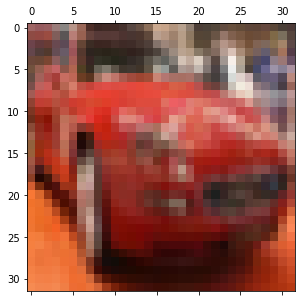

In [3]:
rand_int = random.randint(0,9)
plt.matshow(x_train[random.randint(0,9)])
print(rand_int)

In [4]:
validation_split = 0.7 # 7000 validation / 3000 testing

val_length = int(len(x_test)*validation_split)
test_length = len(x_test)-val_length

x_valid, x_test = torch.utils.data.random_split(x_test, [val_length, test_length],
                                                generator=torch.Generator().manual_seed(42))
y_valid, y_test = torch.utils.data.random_split(y_test, [val_length, test_length],
                                                generator=torch.Generator().manual_seed(42))                                                
                                        
x_valid, x_test, y_valid, y_test = np.array(x_valid), np.array(x_test), np.array(y_valid), np.array(y_test)

print(x_valid.shape)
print(x_test.shape)
print(y_valid.shape)
print(y_test.shape)

(7000, 32, 32, 3)
(3000, 32, 32, 3)
(7000, 1)
(3000, 1)


[8]
[0]


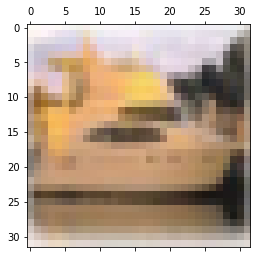

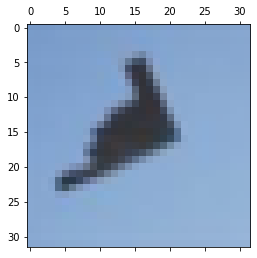

In [5]:
# print images with their labels
print(y_valid[0])
plt.matshow(x_valid[0])
print(y_test[0])
plt.matshow(x_test[0])

In [6]:
# normalising images
x_train = x_train.astype('float32') / 255.0
x_valid = x_valid.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


In [7]:
# CNN: conv -> pooling
# based on VGG model 

folder = 'cnn1_models/'
layers_set = '1conv3fc_128_120_84' # '1conv1fc_128_120_84'


cnn1 = keras.Sequential()
cnn1.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(32, 32, 3)))
cnn1.add(layers.MaxPooling2D((2,2)))
cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(128, activation='relu'))       # classification fc layer
cnn1.add(layers.Dense(120, activation='relu'))       # classification fc layer
cnn1.add(layers.Dense(84, activation='relu'))        # classification fc layer
cnn1.add(layers.Dense(10, activation = 'softmax'))   # 10 categories
print(cnn1.summary())

sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
cnn1.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
filepath = folder + 'best_model_'+ layers_set +'.epoch{epoch:02d}-loss{val_loss:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

history = cnn1.fit(x_train, y_train, epochs=20, batch_size = 32, validation_data=(x_valid, y_valid), callbacks=[checkpoint])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 128)               921728    
                                                                 
 dense_1 (Dense)             (None, 120)               15480     
                                                                 
 dense_2 (Dense)             (None, 84)                10164     
                                                        

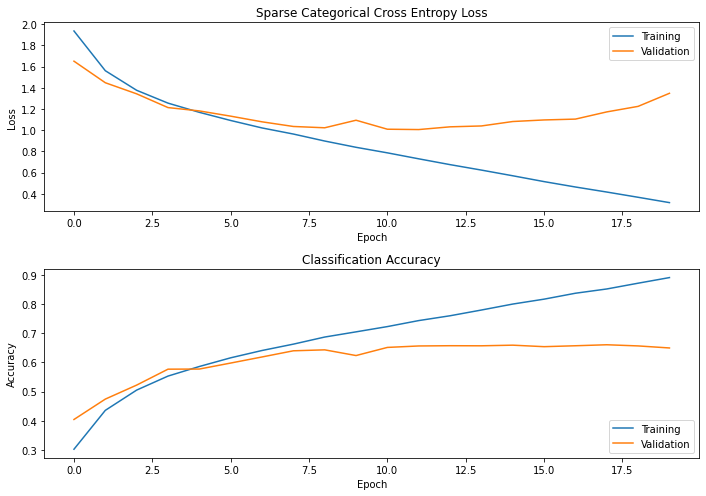

In [8]:
plt.figure(figsize=(10,7))

plt.subplot(211)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation') 
plt.title('Sparse Categorical Cross Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(212)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation') 
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()

In [9]:
# load best model to evaluate performance 
best_model_name = 'best_model_1conv3fc_128_120_84.epoch20-loss0.9990'
cnn1 = keras.models.load_model(folder + best_model_name +'.hdf5')
cnn1.evaluate(x_test, y_test)

94/94 [==============================] - 0s 3ms/step - loss: 1.0341 - accuracy: 0.6507


[1.0341269969940186, 0.6506666541099548]

In [25]:
# CNN: conv -> pooling -> conv -> pooling

folder = 'cnn2_models/'
layers_set = '2conv1fc'

cnn2 = keras.Sequential()
cnn2.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(32, 32, 3)))
cnn2.add(layers.MaxPooling2D((2,2)))
cnn2.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
cnn2.add(layers.MaxPooling2D((2,2)))
cnn2.add(layers.Flatten())
# cnn2.add(layers.Dense(128, activation='relu'))       # classification fc layer
# cnn2.add(layers.Dense(120, activation='relu'))       # classification fc layer
# cnn2.add(layers.Dense(84,  activation='relu'))       # classification fc layer
cnn2.add(layers.Dense(10, activation = 'softmax'))   # 10 categories
print(cnn2.summary())

sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
cnn2.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
filepath = folder + 'best_model_'+ layers_set +'.epoch{epoch:02d}-loss{val_loss:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

history = cnn2.fit(x_train, y_train, epochs=20, batch_size = 32, validation_data=(x_valid, y_valid), callbacks=[checkpoint])


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 1152)              0         
                                                                 
 dense_16 (Dense)            (None, 10)               

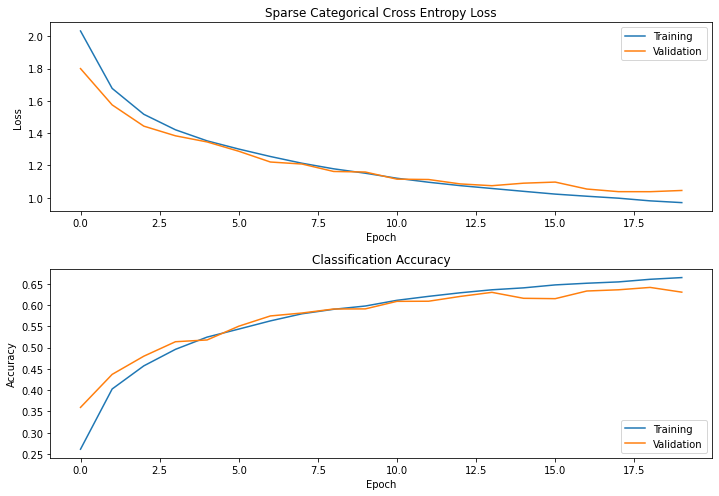

In [26]:
plt.figure(figsize=(10,7))

plt.subplot(211)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation') 
plt.title('Sparse Categorical Cross Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(212)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation') 
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()

In [27]:
from playsound import playsound
playsound('notification.wav') # .mp3 file

In [12]:
# evaluate performance 
best_model_name = 'best_model_2conv3fc.epoch19-loss0.9571'
cnn2 = keras.models.load_model(folder + best_model_name +'.hdf5')
cnn2.evaluate(x_test, y_test)

94/94 [==============================] - 1s 4ms/step - loss: 0.9665 - accuracy: 0.6730


[0.9665374159812927, 0.6729999780654907]

In [13]:
# CNN: conv -> pooling -> conv -> pooling -> conv -> pooling

folder = 'cnn3_models/'
layers_set = '3conv1fc'

cnn3 = keras.Sequential()
cnn3.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(32, 32, 3)))
cnn3.add(layers.MaxPooling2D((2,2)))
cnn3.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
cnn3.add(layers.MaxPooling2D((2,2)))
cnn3.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn3.add(layers.MaxPooling2D((2,2)))
cnn3.add(layers.Flatten())
cnn3.add(layers.Dense(128, activation='relu'))       # classification fc layer
cnn3.add(layers.Dense(120, activation='relu'))       # classification fc layer
cnn3.add(layers.Dense(84,  activation='relu'))       # classification fc layer
cnn3.add(layers.Dense(10, activation = 'softmax'))   # 10 categories    
print(cnn3.summary())

sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
cnn3.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
filepath = folder + 'best_model_'+ layers_set +'.epoch{epoch:02d}-loss{val_loss:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
                             
history = cnn3.fit(x_train, y_train, epochs=20, batch_size = 32, validation_data=(x_valid, y_valid), callbacks=[checkpoint])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 64)        

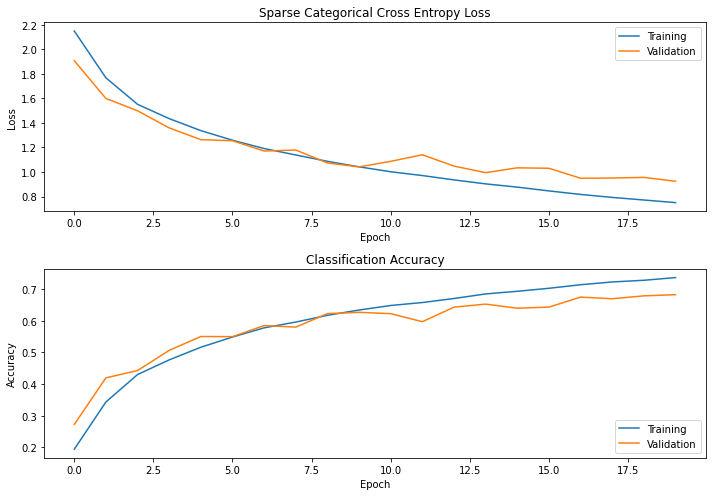

In [14]:
plt.figure(figsize=(10,7))

plt.subplot(211)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation') 
plt.title('Sparse Categorical Cross Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(212)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation') 
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()

In [15]:
# evaluate performance 
best_model_name = 'best_model_3conv1fc.epoch20-loss0.9890'
cnn3 = keras.models.load_model(folder + best_model_name +'.hdf5')
cnn3.evaluate(x_test, y_test)

94/94 [==============================] - 0s 3ms/step - loss: 1.0046 - accuracy: 0.6680


[1.0045682191848755, 0.6679999828338623]

In [21]:
# CNN: conv -> pooling -> conv -> pooling -> conv -> pooling -> conv -> pooling

folder = 'cnn4_models/'
layers_set = '4conv1fc'


cnn4 = keras.Sequential()
cnn4.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(32, 32, 3)))
cnn4.add(layers.MaxPooling2D((2,2)))
cnn4.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
cnn4.add(layers.MaxPooling2D((2,2)))
cnn4.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
cnn4.add(layers.MaxPooling2D((2,2)))
cnn4.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
cnn4.add(layers.MaxPooling2D((2,2)))
cnn4.add(layers.Flatten())
cnn4.add(layers.Dense(128, activation='relu'))       # classification fc layer
# cnn4.add(layers.Dense(120, activation='relu'))       # classification fc layer
# cnn4.add(layers.Dense(84, activation='relu'))       # classification fc layer
cnn4.add(layers.Dense(10, activation = 'softmax'))   # 10 categories    
print(cnn4.summary())

sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
cnn4.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
filepath = folder + 'best_model_'+ layers_set +'.epoch{epoch:02d}-loss{val_loss:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

history = cnn4.fit(x_train, y_train, epochs=20, batch_size = 32, validation_data=(x_valid, y_valid), callbacks=[checkpoint])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 4, 4, 64)        

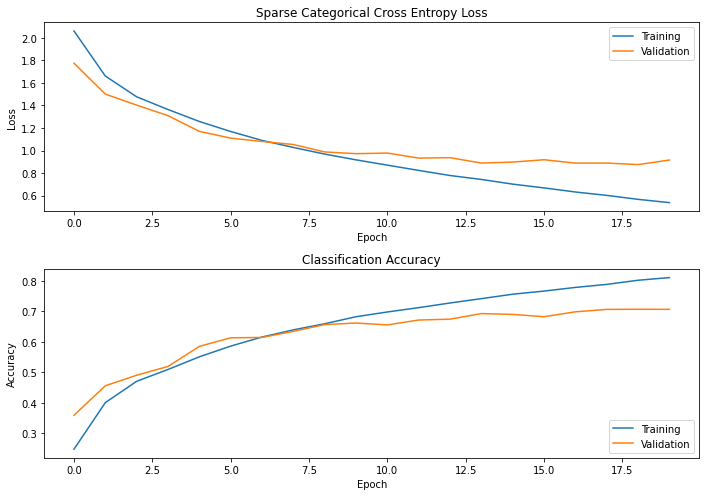

In [22]:
plt.figure(figsize=(10,7))

plt.subplot(211)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation') 
plt.title('Sparse Categorical Cross Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(212)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation') 
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()

94/94 [==============================] - 1s 6ms/step


Text(69.0, 0.5, 'Truth')

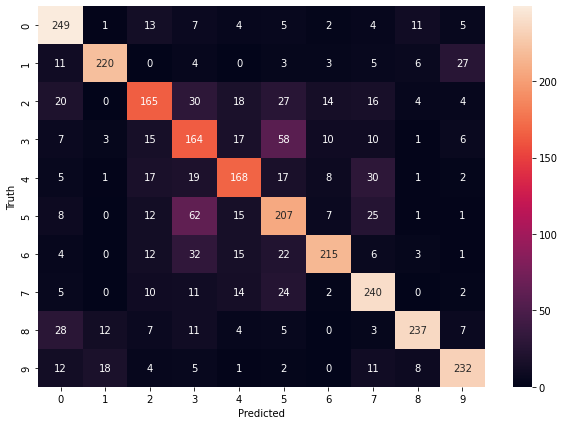

In [23]:
y_predicted = cnn4.predict(x_test)
y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)
plt.figure(figsize=(10,7))
seaborn.heatmap(cm,annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [24]:
from playsound import playsound
playsound('notification.wav') # .mp3 file

In [20]:
# evaluate performance 
best_model_name = 'best_model_4conv1fc.epoch19-loss0.8941'
cnn4 = keras.models.load_model(folder + best_model_name +'.hdf5')
cnn4.evaluate(x_test, y_test)

OSError: No file or directory found at cnn4_models/best_model_4conv1fc.epoch19-loss0.8941.hdf5

In [ ]:
rand_int = random.randint(0,len(x_test))

test_img = x_test[rand_int]
plt.matshow(test_img)

result = cnn4.predict(test_img.reshape((1,32,32,3))) # X_test[rand].reshape((1,32,32,3))
predicted_class = np.argmax(result)
predicted_class_name = class_names[predicted_class]
print(predicted_class_name)